In [1]:
import os 
import glob
imdb_dir = '/Users/halahalsaadi/Downloads/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


In [2]:
# Import various modules for string cleaning
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

In [3]:
import re


def clean_text(text): 
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text) 
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

In [4]:

def tfidf_process(data):
	from sklearn.feature_extraction.text import TfidfTransformer 
	transformer = TfidfTransformer()
	transformer = transformer.fit(data)
	return transformer

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 100 
training_samples = 1500
validation_samples = 500
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 88582 unique tokens.


In [6]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [7]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]



x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples] 
y_val = labels[training_samples: training_samples + validation_samples]


In [8]:
glove_dir = '/Users/halahalsaadi/Downloads/glove'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [9]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [13]:
epochs = 15
batch_size = 128

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from keras.layers import LSTM


model = Sequential()
model.add(Embedding(max_words, 100))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,084,609
Trainable params: 1,084,609
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')


Train on 1500 samples, validate on 500 samples
Epoch 1/15
1500/1500 [==============================] - 6s 4ms/step - loss: 0.6894 - acc: 0.5433 - val_loss: 0.6690 - val_acc: 0.5820
Epoch 2/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6658 - acc: 0.5987 - val_loss: 0.6463 - val_acc: 0.6460
Epoch 3/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6365 - acc: 0.6627 - val_loss: 0.6050 - val_acc: 0.6780
Epoch 4/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5974 - acc: 0.6833 - val_loss: 0.6127 - val_acc: 0.6540
Epoch 5/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5668 - acc: 0.7047 - val_loss: 0.5955 - val_acc: 0.6980
Epoch 6/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5505 - acc: 0.7167 - val_loss: 0.5559 - val_acc: 0.6900
Epoch 7/15
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5116 - acc: 0.7553 - val_loss: 0.5232 - val_acc: 0.7240
Epoch 8/15
1500

In [17]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

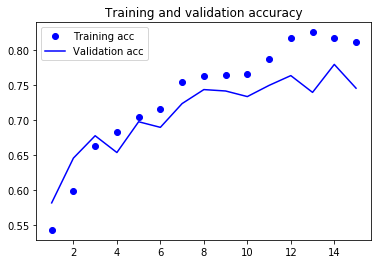

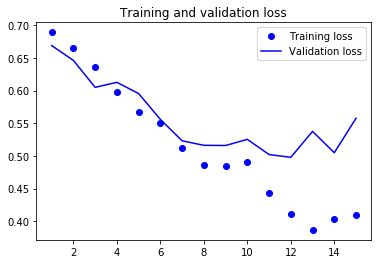

In [18]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
score, acc = model.evaluate(x_train, y_train)
print('Test score:', score)
print('Test accuracy:', score)

1500/1500 [==============================] - 2s 1ms/step
Test score: 0.42096656743685407
Test accuracy: 0.42096656743685407


In [21]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
        
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)


In [22]:
model.load_weights('pre_trained_glove_model.h5')
score, acc = model.evaluate(x_test, y_test)

25000/25000 [==============================] - 26s 1ms/step


In [24]:
print('Test Score:', score)
print('Test Accuracy:', acc)

Test Score: 0.6082023483371735
Test Accuracy: 0.73172
